<a href="https://colab.research.google.com/github/msalmankhan03/Vision-Transfarmer/blob/main/ViT_on_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cuda


100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Sizes -> train: 45000 val: 5000 test: 10000
SimpleViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x ModuleDict(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=384, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=384, out_features=128, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=128, out_features=10, bias=True)

Epoch 1/6 - Train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/6 | Train Loss: 1.8486 | Train Acc: 31.39% | Val Loss: 1.6673 | Val Acc: 38.94%


Epoch 2/6 - Train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2/6 | Train Loss: 1.5500 | Train Acc: 42.74% | Val Loss: 1.4254 | Val Acc: 47.54%


Epoch 3/6 - Train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3/6 | Train Loss: 1.3824 | Train Acc: 49.82% | Val Loss: 1.3272 | Val Acc: 51.78%


Epoch 4/6 - Train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4/6 | Train Loss: 1.2810 | Train Acc: 53.62% | Val Loss: 1.2245 | Val Acc: 55.50%


Epoch 5/6 - Train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5/6 | Train Loss: 1.2051 | Train Acc: 56.16% | Val Loss: 1.1692 | Val Acc: 58.42%


Epoch 6/6 - Train:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6/6 | Train Loss: 1.1593 | Train Acc: 58.00% | Val Loss: 1.1359 | Val Acc: 59.68%


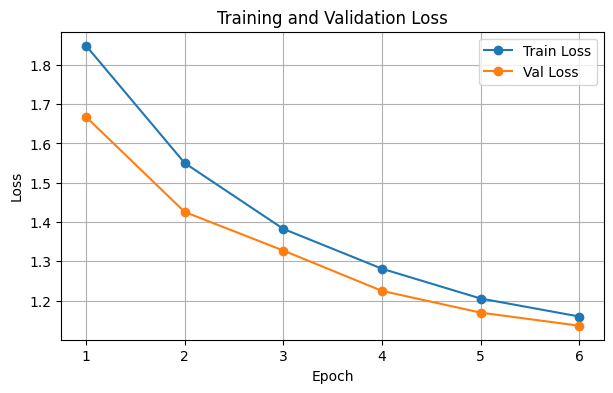

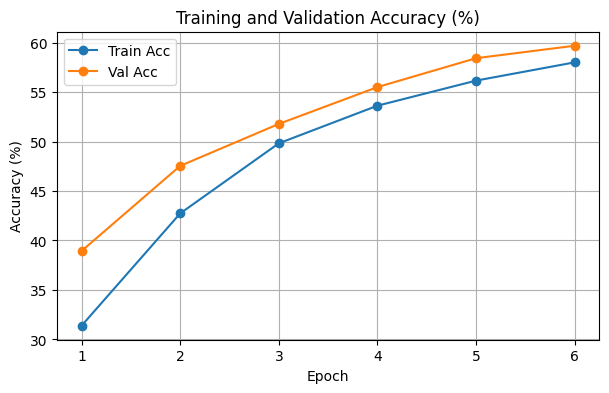

Test eval:   0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 58.51%


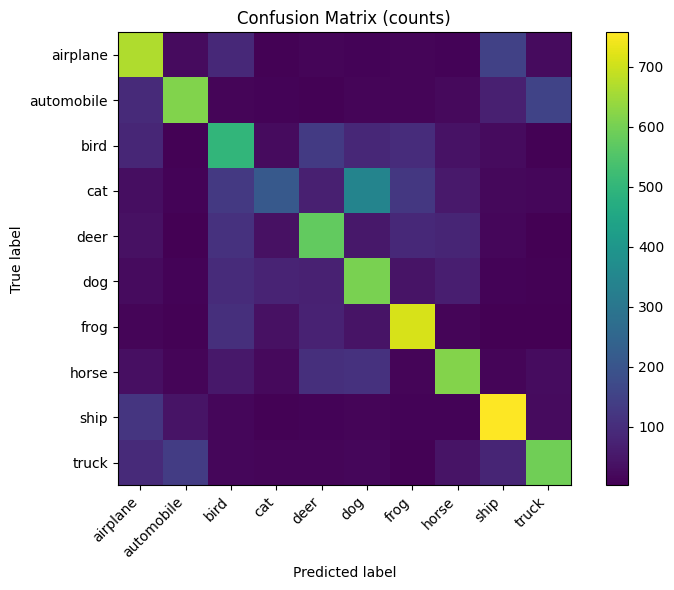

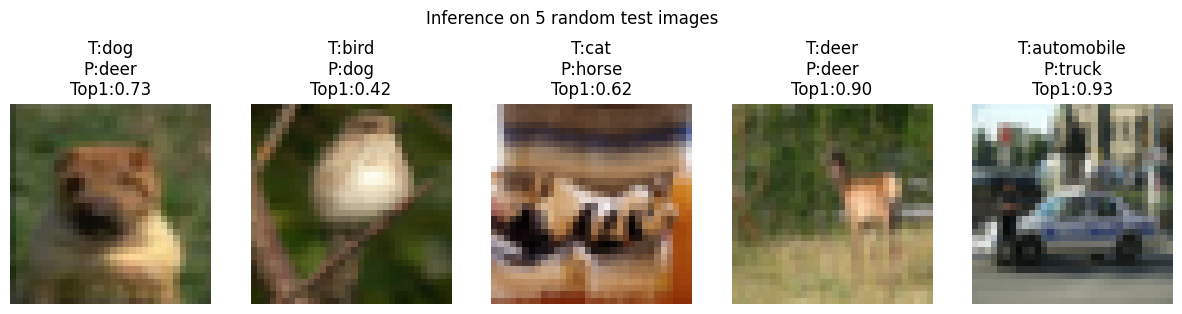

Saved model to: /mnt/data/vit_cifar10.pth


In [1]:
# Simple ViT project on CIFAR-10

import os
import random
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --------------------------
# 0. Reproducibility & device
# --------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------------------------
# 1. Data preparation
# --------------------------
# CIFAR-10 images are 32x32 RGB. We'll use a patch size of 4 (-> 8x8 patches -> 64 tokens).
batch_size = 128
num_workers = 2

# CIFAR-10 normalization stats
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

root_data = "/mnt/data/cifar10_data"
train_full = datasets.CIFAR10(root=root_data, train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root=root_data, train=False, download=True, transform=transform_test)

# create hold-out validation set
val_size = 5000
train_size = len(train_full) - val_size
train_dataset, val_dataset = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

class_names = train_full.classes
print("Classes:", class_names)
print("Sizes -> train:", len(train_dataset), "val:", len(val_dataset), "test:", len(test_dataset))

# --------------------------
# 2. Simple ViT implementation
# --------------------------
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=128):
        super().__init__()
        assert img_size % patch_size == 0
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        # Conv2d extracts patches and projects to embedding dimension
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.proj(x)  # [B, embed_dim, H/ps, W/ps]
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        return x

class SimpleViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=128, depth=6, num_heads=4, mlp_ratio=3.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)

        # Create 'depth' transformer blocks
        self.blocks = nn.ModuleList([
            nn.ModuleDict({
                "ln1": nn.LayerNorm(embed_dim),
                "attn": nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True),
                "ln2": nn.LayerNorm(embed_dim),
                "mlp": nn.Sequential(
                    nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
                    nn.GELU(),
                    nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
                    nn.Dropout(dropout)
                )
            }) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.xavier_uniform_(self.head.weight)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B, N, C]
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B,1,C]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, 1+N, C]
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x_norm = blk["ln1"](x)
            attn_out, _ = blk["attn"](x_norm, x_norm, x_norm, need_weights=False)
            x = x + attn_out
            x_norm = blk["ln2"](x)
            x = x + blk["mlp"](x_norm)
        x = self.norm(x)
        cls = x[:, 0]
        out = self.head(cls)
        return out

model = SimpleViT(img_size=32, patch_size=4, in_chans=3, num_classes=10,
                  embed_dim=128, depth=6, num_heads=4, mlp_ratio=3.0, dropout=0.1).to(device)
print(model)
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# --------------------------
# 3. Training setup
# --------------------------
epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# --------------------------
# 4. Train + validate and record metrics
# --------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Train", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    scheduler.step()
    print(f"Epoch {epoch}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc*100:.2f}% "
          f"| Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc*100:.2f}%")

# --------------------------
# 5. Plot training curves (each plot is a separate figure)
# --------------------------
# Loss curve
plt.figure(figsize=(7,4))
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, marker='o', label='Val Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy curve
plt.figure(figsize=(7,4))
plt.plot(range(1, epochs+1), [x*100 for x in train_accs], marker='o', label='Train Acc')
plt.plot(range(1, epochs+1), [x*100 for x in val_accs], marker='o', label='Val Acc')
plt.title("Training and Validation Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 6. Test evaluation and confusion matrix
# --------------------------
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test eval", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
test_acc = (all_preds == all_labels).mean()
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion matrix
num_classes = len(class_names)
conf_mat = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(all_labels, all_preds):
    conf_mat[t, p] += 1

plt.figure(figsize=(8,6))
plt.imshow(conf_mat)
plt.title("Confusion Matrix (counts)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(ticks=np.arange(num_classes), labels=class_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(num_classes), labels=class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

# --------------------------
# 7. Inference on 5 random test images
# --------------------------
# For display we will use an unnormalized version of images (0..1)
test_raw = datasets.CIFAR10(root=root_data, train=False, download=False, transform=transforms.ToTensor())
rng = np.random.default_rng(seed=seed+1)
indices = rng.choice(len(test_raw), size=5, replace=False)

plt.figure(figsize=(15,4))
for i, idx in enumerate(indices):
    img, true_label = test_raw[idx]  # [C,H,W] in 0..1
    # Prepare a normalized version for model input
    img_norm = transforms.Normalize(mean, std)(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(img_norm)
        probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
        pred = probs.argmax()
    ax = plt.subplot(1,5,i+1)
    ax.imshow(np.transpose(img.numpy(), (1,2,0)))
    ax.axis('off')
    ax.set_title(f"T:{class_names[true_label]}\nP:{class_names[pred]}\nTop1:{probs[pred]:.2f}")
plt.suptitle("Inference on 5 random test images")
plt.show()

# --------------------------
# 8. Save model checkpoint
# --------------------------
save_path = "/mnt/data/vit_cifar10.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "class_names": class_names
}, save_path)
print("Saved model to:", save_path)
